In [1]:
import math
import torch
import gpytorch
from gpytorch.kernels import RBFKernel
from matplotlib import pyplot as plt
import numpy as np
import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
data = np.genfromtxt("../../heron/models/data/gt-M60-F1024.dat")

In [3]:
data[:,0] = data[:,0] * 1000
data[:,1] = np.log(data[:,1])
data[:,-2] = data[:,-2] * 1e19
data[:,-1] = data[:,-1] * 1e19
training_x = torch.tensor(data[:,:8]).float()
training_y = torch.tensor(data[:,[-2, -1]]).float()

In [4]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(training_x, training_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

#test_dataset = TensorDataset(test_x, test_y)
#test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [5]:
from functools import reduce
import operator
def prod(iterable):
    return reduce(operator.mul, iterable)

In [6]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

In [7]:
class TorchHeron(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(TorchHeron, self).__init__(training_x, training_y, likelihood)
        self.mean_module =  gpytorch.means.ZeroMean()
        self.covar_module = prod([RBFKernel(active_dims=torch.tensor([i])) for i in range(8)])

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [29]:
class TorchBigHeron(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        
        
        variational_distribution = CholeskyVariationalDistribution(
            inducing_points.size(-2), 
            batch_shape=torch.Size([2]))
        
        variational_strategy = gpytorch.variational.MultitaskVariationalStrategy(
            VariationalStrategy(self, inducing_points, 
                                variational_distribution, 
                                learn_inducing_locations=True),
            num_tasks=2)
        
        super(TorchBigHeron, self).__init__(variational_strategy)
        
        self.mean_module =  gpytorch.means.ConstantMean(batch_shape=torch.Size([2]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            #RBFKernel(batch_shape=torch.Size([2])), 
            prod([RBFKernel(active_dims=torch.tensor([i]), 
                            batch_shape=torch.Size([2])) for i in range(8)]),
                            lengthscale_contraint = gpytorch.constraints.GreaterThan(0.7),
                            batch_shape = torch.Size([2]))
            # RBFKernel(batch_shape=torch.Size([2]))#

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [30]:
inducing_points = torch.tensor(np.dstack([training_x[:500,:].T, training_x[500:1000,:].T]).T) # torch.tensor(np.dstack([training_x[:500,:].T, training_x[:500,:].T]))
#inducing_points[:,:,0]*=100
model = TorchBigHeron(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)

In [31]:
num_epochs = 50

model.train()
likelihood.train()

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=training_y.size(0))


epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.tqdm_notebook(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()

/home/daniel/.virtualenvs/aries/sandbox/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


/home/daniel/.virtualenvs/aries/sandbox/lib/python3.6/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [32]:
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (noise_covar): MultitaskHomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [33]:
test_x = torch.tensor(data[0:50, :8]).float()
test_y = torch.tensor(data[0:50, -2]).float()


In [34]:
test_x = np.ones([1000, 8]) 
test_x = test_x * data[0, :8]
test_x[:,0] = np.linspace(-15, 20, 1000)
test_x[:,1] = np.ones(1000) * np.log(.5)
test_x[:,2:] = np.ones((1000,6)) * [0.,0,-0,0,0,0.0]
test_x = torch.tensor(test_x).float()

In [35]:
#%%timeit
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    f_preds = model(test_x)
    y_preds = likelihood(f_preds)

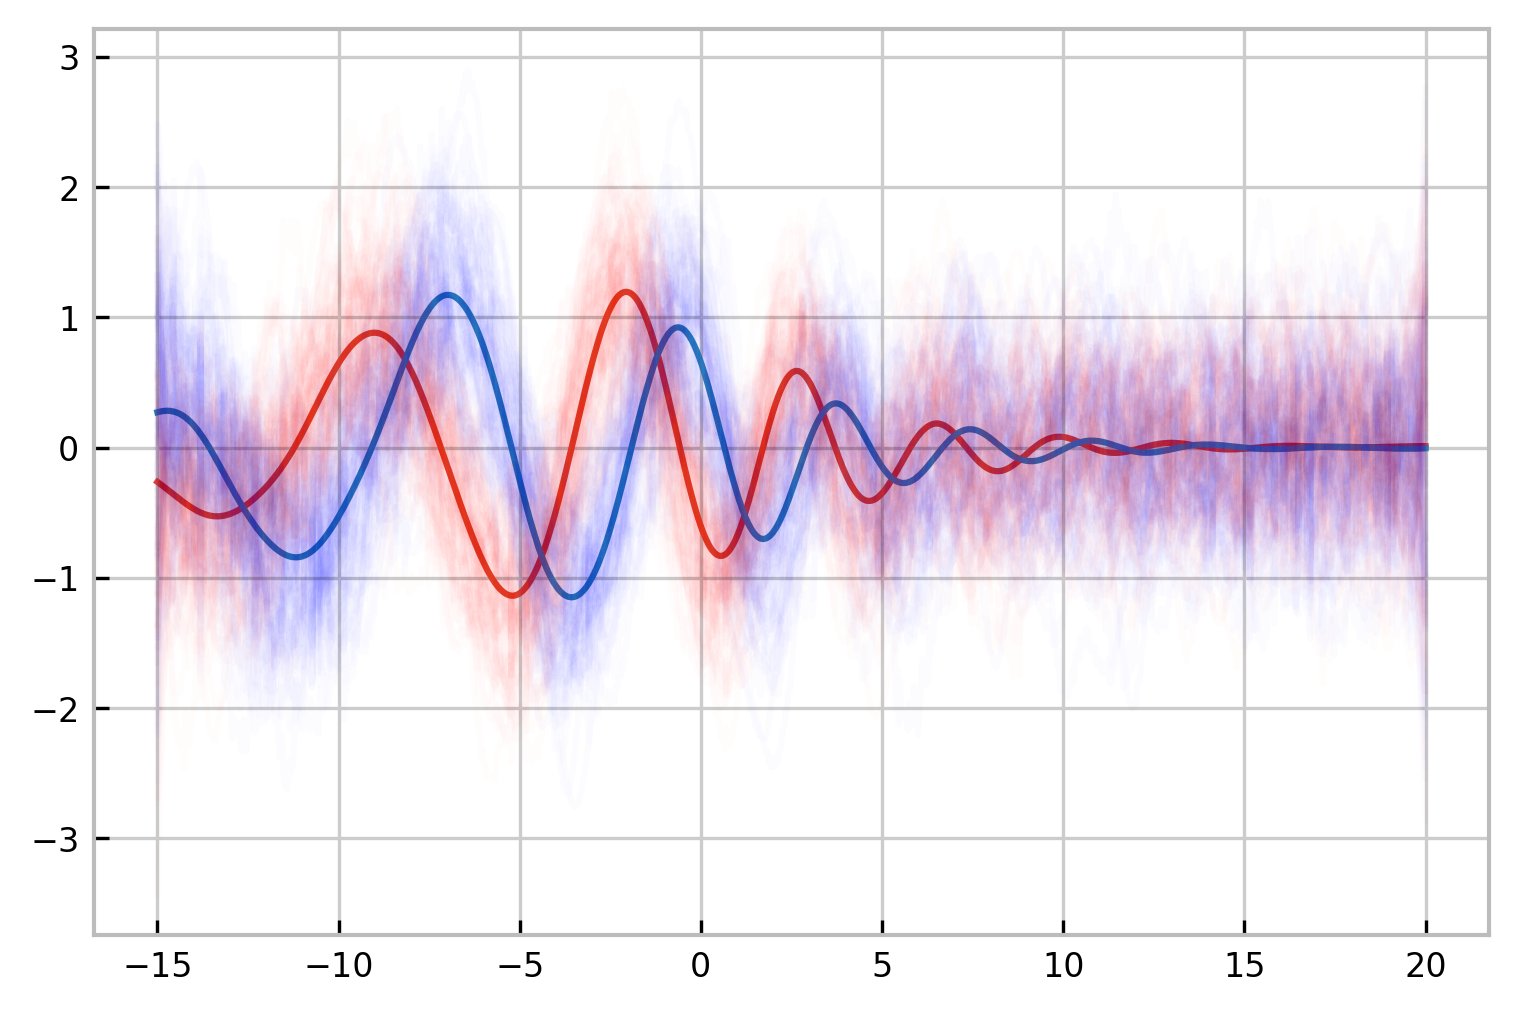

In [36]:
with torch.no_grad():
    lower, upper = y_preds.confidence_region()
    f, ax = plt.subplots(1,1, dpi=300)
    ax.plot(test_x[:,0].numpy(), f_preds.mean.numpy()[:,0])
    ax.plot(test_x[:,0].numpy(), f_preds.mean.numpy()[:,1])
    
    samples = y_preds.sample_n(100)
    for sample in samples:
        ax.plot(test_x[:,0].numpy(), sample.numpy()[:,0], alpha=0.01, color='r')
        ax.plot(test_x[:,0].numpy(), sample.numpy()[:,1], alpha=0.01, color='b')
    
    #ax.fill_between(test_x[:,0].numpy(), lower[0].numpy(), upper.numpy(), alpha=0.5)